In [1]:
from mapc_research.scalability import *

DB_PATH_PULP = "/Users/wciezobka/ncn/mapc-optimal-research/mapc_research/scalability/database/pulp.csv"
DB_PATH_CPLEX = "/Users/wciezobka/ncn/mapc-optimal-research/mapc_research/scalability/database/cplex.csv"

In [2]:
df_pulp = pd.read_csv(DB_PATH_PULP)
df_cplex = pd.read_csv(DB_PATH_CPLEX)

In [3]:
df_pulp["n_aps"] = df_pulp["x_aps"] * df_pulp["y_aps"]
df_cplex["n_aps"] = df_cplex["x_aps"] * df_cplex["y_aps"]

df_cplex = df_cplex.drop([32, 42, 57, 70, 75, 88, 92])  # remove outliers for CPLEX

df_pulp = df_pulp.sort_values(by=["n_aps", "repetition"])
df_cplex = df_cplex.sort_values(by=["n_aps", "repetition"])

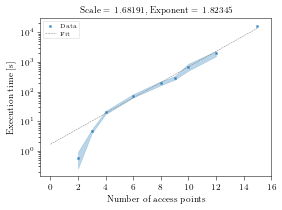

In [4]:
plot_results(df_pulp[["n_aps", "time"]], n_aps_threshold=4, save_path="pulp.pdf")

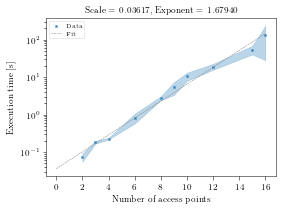

In [5]:
plot_results(df_cplex[["n_aps", "time"]], n_aps_threshold=0, save_path="cplex.pdf")

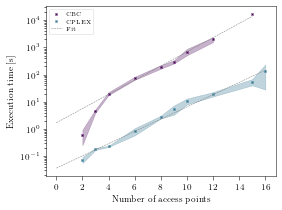

In [6]:
plot_combined(
    dfs=[df_pulp[["n_aps", "time"]], df_cplex[["n_aps", "time"]]],
    labels=["CBC", "CPLEX"],
    n_aps_thresholds=[4, 0],
    save_path="combined.pdf"
)